/tmp/ipython-input-2711131798.py:63: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")


✅ ETL finished successfully
Rows: 140
Columns: ['timestamp', 'your_academic_stage', 'peer_pressure', 'academic_pressure_from_your_home', 'study_environment', 'what_coping_strategy_you_use_as_a_student', 'do_you_have_any_bad_habits_like_smoking_drinking_on_a_daily_basis', 'what_would_you_rate_the_academic_competition_in_your_student_life', 'rate_your_academic_stress_index', 'high_peer_pressure_flag']
Saved clean data to: data/processed/student_stress_clean.csv

✅ Descriptive tables saved:
 - data/analysis/peer_pressure_by_study_environment.csv
 - data/analysis/peer_pressure_distribution_by_environment.csv
 - data/analysis/pct_high_peer_pressure_by_environment.csv

📌 Peer Pressure by Study Environment (avg/median/count):
study_environment  avg_peer_pressure  median_peer_pressure  count      std
        disrupted           3.578947                   4.0     38 0.889323
            noisy           3.031250                   3.0     32 1.282245
         peaceful           2.782609          

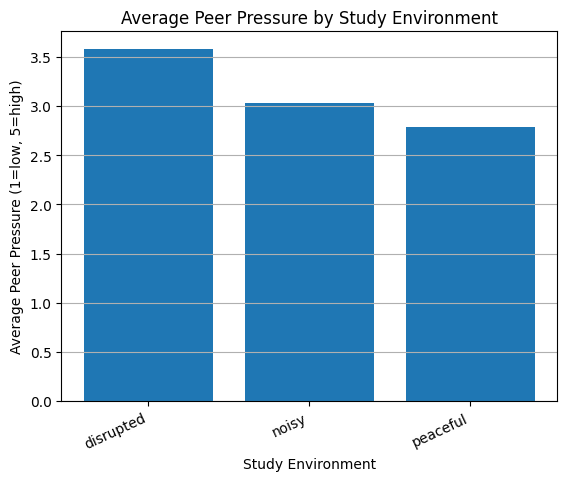


Saved plot: data/analysis/avg_peer_pressure_by_environment.png


<Figure size 640x480 with 0 Axes>

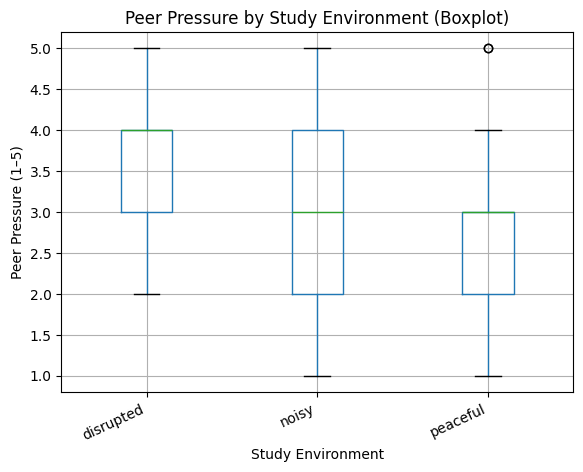

Saved plot: data/analysis/boxplot_peer_pressure_by_environment.png

📌 Kruskal-Wallis test
H: 13.422139546235725
p-value: 0.001217361127561417
Effect size (epsilon-squared): 0.08398632019290975
Saved stats: data/analysis/kruskal_results.txt

✅ Post-hoc pairwise Mann–Whitney (Bonferroni) saved:
 - data/analysis/posthoc_mannwhitney_bonferroni.csv

Top results (smallest adjusted p-values):
  group_1  group_2      U  p_value  p_adj_bonferroni
disrupted peaceful 1868.0 0.000120          0.000359
disrupted    noisy  762.0 0.061000          0.183000
    noisy peaceful 1216.5 0.390662          1.000000

✅ Analysis finished successfully


In [8]:
# ============================================
# ETL + Analysis (categorical Study Environment)
# - Descriptive tables
# - Boxplot
# - Kruskal-Wallis test (recommended for ordinal 1–5)
# - Effect size (epsilon-squared)
# - Optional post-hoc pairwise Mann–Whitney (Bonferroni)
# ============================================

import os
import itertools
import pandas as pd
import matplotlib.pyplot as plt

# ========= CONFIG =========
RAW_PATH = "/content/sample_data/academic Stress level - maintainance 1.csv"
OUT_DIR = "data/processed"
OUT_PATH = os.path.join(OUT_DIR, "student_stress_clean.csv")

ANALYSIS_DIR = "data/analysis"
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(ANALYSIS_DIR, exist_ok=True)

# ========= ETL =========
def standardize_columns(df: pd.DataFrame) -> pd.DataFrame:
    df.columns = (
        df.columns.astype(str)
        .str.strip()
        .str.lower()
        .str.replace(r"[^\w\s]", "", regex=True)
        .str.replace(r"\s+", "_", regex=True)
    )
    return df


def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    df = df.drop_duplicates()
    df = df.dropna(how="all")

    # peer_pressure -> numeric
    if "peer_pressure" in df.columns:
        df["peer_pressure"] = pd.to_numeric(df["peer_pressure"], errors="coerce")

    # study_environment -> categorical text
    if "study_environment" in df.columns:
        df["study_environment"] = (
            df["study_environment"]
            .astype(str)
            .str.strip()
            .str.lower()
            .str.replace(r"\s+", " ", regex=True)
        )

        # Optional normalization
        df["study_environment"] = df["study_environment"].replace({
            "disruptive": "disrupted",
            "noisy and disrupted": "noisy/disrupted",
            "noisy & disrupted": "noisy/disrupted",
        })

    # optional timestamp
    if "timestamp" in df.columns:
        df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")

    return df


def create_features(df: pd.DataFrame) -> pd.DataFrame:
    # simple flag for "high pressure"
    if "peer_pressure" in df.columns:
        df["high_peer_pressure_flag"] = df["peer_pressure"] >= 4
    return df


def run_etl() -> pd.DataFrame:
    df = pd.read_csv(RAW_PATH)
    df = standardize_columns(df)
    df = clean_data(df)
    df = create_features(df)

    df.to_csv(OUT_PATH, index=False)

    print("✅ ETL finished successfully")
    print("Rows:", len(df))
    print("Columns:", list(df.columns))
    print("Saved clean data to:", OUT_PATH)

    return df


# ========= ANALYSIS =========
def epsilon_squared_kruskal(H: float, n: int, k: int) -> float:
    """
    Effect size for Kruskal-Wallis (epsilon-squared).
    Common formula: (H - k + 1) / (n - k)
    """
    if n <= k:
        return float("nan")
    return (H - k + 1) / (n - k)


def analyze_peer_pressure_vs_study_environment(df: pd.DataFrame):
    # --- basic checks
    for col in ["peer_pressure", "study_environment"]:
        if col not in df.columns:
            raise ValueError(f"Missing column '{col}'. Available: {list(df.columns)}")

    # --- keep valid rows only
    dfa = df[["peer_pressure", "study_environment"]].copy()

    # Remove NA real
    dfa = dfa[dfa["peer_pressure"].notna()]
    dfa = dfa[dfa["study_environment"].notna()]

    # Remove string "nan"
    dfa = dfa[dfa["study_environment"].str.lower() != "nan"]

    # Ensure that peer_pressure is between 1 and 5
    dfa = dfa[dfa["peer_pressure"].between(1, 5)]

    # --- descriptive table
    desc = (
        dfa.groupby("study_environment")["peer_pressure"]
           .agg(
               avg_peer_pressure="mean",
               median_peer_pressure="median",
               count="count",
               std="std"
           )
           .reset_index()
           .sort_values("avg_peer_pressure", ascending=False)
    )
    desc_path = os.path.join(ANALYSIS_DIR, "peer_pressure_by_study_environment.csv")
    desc.to_csv(desc_path, index=False)

    # --- distribution table (% of 1..5 within each environment)
    dist = (
        dfa.groupby("study_environment")["peer_pressure"]
           .value_counts(normalize=True)
           .rename("pct")
           .reset_index()
           .sort_values(["study_environment", "peer_pressure"])
    )
    dist_path = os.path.join(ANALYSIS_DIR, "peer_pressure_distribution_by_environment.csv")
    dist.to_csv(dist_path, index=False)

    # --- high pressure % (>=4)
    dfa2 = dfa.copy()
    dfa2["high_peer_pressure_flag"] = dfa2["peer_pressure"] >= 4
    high_tbl = (
        dfa2.groupby("study_environment")["high_peer_pressure_flag"]
            .mean()
            .reset_index(name="pct_high_peer_pressure")
            .sort_values("pct_high_peer_pressure", ascending=False)
    )
    high_path = os.path.join(ANALYSIS_DIR, "pct_high_peer_pressure_by_environment.csv")
    high_tbl.to_csv(high_path, index=False)

    print("\n✅ Descriptive tables saved:")
    print(" -", desc_path)
    print(" -", dist_path)
    print(" -", high_path)

    print("\n📌 Peer Pressure by Study Environment (avg/median/count):")
    print(desc.to_string(index=False))

    # ========= VISUALS =========
    # A) Bar chart: average peer pressure
    plt.figure()
    plt.bar(desc["study_environment"], desc["avg_peer_pressure"])
    plt.title("Average Peer Pressure by Study Environment")
    plt.xlabel("Study Environment")
    plt.ylabel("Average Peer Pressure (1=low, 5=high)")
    plt.xticks(rotation=25, ha="right")
    plt.grid(True, axis="y")
    fig1_path = os.path.join(ANALYSIS_DIR, "avg_peer_pressure_by_environment.png")
    plt.savefig(fig1_path, bbox_inches="tight")
    plt.show()
    print("\nSaved plot:", fig1_path)

    # B) Boxplot (best quick viz for ordinal comparisons)
    plt.figure()
    # pandas boxplot will order categories alphabetically; we can preserve the order from desc:
    ordered_envs = desc["study_environment"].tolist()
    dfa_ordered = dfa.copy()
    dfa_ordered["study_environment"] = pd.Categorical(
        dfa_ordered["study_environment"], categories=ordered_envs, ordered=True
    )
    dfa_ordered.boxplot(column="peer_pressure", by="study_environment")
    plt.title("Peer Pressure by Study Environment (Boxplot)")
    plt.suptitle("")
    plt.xlabel("Study Environment")
    plt.ylabel("Peer Pressure (1–5)")
    plt.xticks(rotation=25, ha="right")
    plt.grid(True, axis="y")
    fig2_path = os.path.join(ANALYSIS_DIR, "boxplot_peer_pressure_by_environment.png")
    plt.savefig(fig2_path, bbox_inches="tight")
    plt.show()
    print("Saved plot:", fig2_path)

    # ========= STATS: Kruskal-Wallis + effect size =========
    # Kruskal-Wallis is appropriate because peer_pressure is ordinal (1..5) and study_environment is categorical.
    try:
        from scipy.stats import kruskal, mannwhitneyu

        # Build groups
        groups = []
        group_names = []
        for env, g in dfa.groupby("study_environment"):
            vals = g["peer_pressure"].dropna().values
            if len(vals) > 0:
                groups.append(vals)
                group_names.append(env)

        k = len(groups)
        n = int(dfa["peer_pressure"].notna().sum())

        if k < 2:
            print("\n⚠️ Not enough groups for Kruskal-Wallis (need at least 2).")
            return

        H, p = kruskal(*groups)
        eps2 = epsilon_squared_kruskal(H, n, k)

        stats_path = os.path.join(ANALYSIS_DIR, "kruskal_results.txt")
        with open(stats_path, "w") as f:
            f.write(f"Kruskal-Wallis H: {H}\n")
            f.write(f"p-value: {p}\n")
            f.write(f"epsilon_squared: {eps2}\n")
            f.write(f"groups: {group_names}\n")
            f.write(f"n: {n}, k: {k}\n")

        print("\n📌 Kruskal-Wallis test")
        print("H:", H)
        print("p-value:", p)
        print("Effect size (epsilon-squared):", eps2)
        print("Saved stats:", stats_path)

        # ========= OPTIONAL: Post-hoc pairwise tests (only if significant) =========
        # If p < 0.05, we can run pairwise Mann–Whitney U tests with Bonferroni correction.
        if p < 0.05 and k >= 3:
            pairs = list(itertools.combinations(range(k), 2))
            m = len(pairs)  # number of comparisons

            posthoc_rows = []
            for i, j in pairs:
                g1, g2 = groups[i], groups[j]
                name1, name2 = group_names[i], group_names[j]

                # two-sided test
                U, p_pair = mannwhitneyu(g1, g2, alternative="two-sided")

                # Bonferroni correction
                p_adj = min(p_pair * m, 1.0)

                posthoc_rows.append({
                    "group_1": name1,
                    "group_2": name2,
                    "U": U,
                    "p_value": p_pair,
                    "p_adj_bonferroni": p_adj
                })

            posthoc_df = pd.DataFrame(posthoc_rows).sort_values("p_adj_bonferroni")
            posthoc_path = os.path.join(ANALYSIS_DIR, "posthoc_mannwhitney_bonferroni.csv")
            posthoc_df.to_csv(posthoc_path, index=False)

            print("\n✅ Post-hoc pairwise Mann–Whitney (Bonferroni) saved:")
            print(" -", posthoc_path)
            print("\nTop results (smallest adjusted p-values):")
            print(posthoc_df.head(10).to_string(index=False))
        else:
            print("\n(Info) Post-hoc tests skipped (either not significant or only 2 groups).")

    except ImportError:
        print("\n⚠️ SciPy is not installed in this environment.")
        print("In Colab, run:  !pip install scipy")
        print("Then rerun the analysis cell.")


def main():
    df = run_etl()
    analyze_peer_pressure_vs_study_environment(df)
    print("\n✅ Analysis finished successfully")


if __name__ == "__main__":
    main()

